In [388]:
import os
import numpy as np
from sklearn import mixture
import pandas as pd
import re
import scipy.stats as stats
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [389]:
#change path
path="..\\UB_keystroke_dataset\\S0"

In [390]:
def ReadListOfTextFilesFromDirectoryWalk(path):
    """Read all text files from given directory and its sudirectories and return list of text files path"""
    files = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if '.txt' in file:
                files.append(os.path.join(r, file))
    return files



In [391]:
files=ReadListOfTextFilesFromDirectoryWalk(path)
len(files)
print(files[0:1])

['..\\UB_keystroke_dataset\\S0\\baseline\\001000.txt']


In [392]:
def CreateListOfTuplesFromFile(files):
#Reading file and create tuple 
    items = []
    for file in files:
        filename=file.split('\\')[-1].split('.')[0]
        f=open(file, "r")
        for line in f:
            words= line.rstrip('\n').split(sep=" ")
            items.append((words[0],words[1],words[2],filename))
    return items


In [393]:
items=CreateListOfTuplesFromFile(files[0:10])
items

[('LMenu', 'KeyDown', '63578429757751', '001000'),
 ('Tab', 'KeyDown', '63578429757861', '001000'),
 ('LMenu', 'KeyUp', '63578429757970', '001000'),
 ('Tab', 'KeyUp', '63578429757985', '001000'),
 ('LMenu', 'KeyDown', '63578429761511', '001000'),
 ('Tab', 'KeyDown', '63578429761589', '001000'),
 ('LMenu', 'KeyUp', '63578429761698', '001000'),
 ('Tab', 'KeyUp', '63578429761729', '001000'),
 ('LMenu', 'KeyDown', '63578429762229', '001000'),
 ('Tab', 'KeyDown', '63578429762291', '001000'),
 ('LMenu', 'KeyUp', '63578429762416', '001000'),
 ('Tab', 'KeyUp', '63578429762447', '001000'),
 ('LMenu', 'KeyDown', '63578429762837', '001000'),
 ('Tab', 'KeyDown', '63578429762931', '001000'),
 ('Tab', 'KeyUp', '63578429763071', '001000'),
 ('Tab', 'KeyDown', '63578429763789', '001000'),
 ('Tab', 'KeyUp', '63578429763882', '001000'),
 ('LMenu', 'KeyUp', '63578429764085', '001000'),
 ('D0', 'KeyDown', '63578429768578', '001000'),
 ('D0', 'KeyUp', '63578429768656', '001000'),
 ('D0', 'KeyDown', '635784

In [394]:
#Creating dataframes
def CreateDataFrame(items,columns):
    df = pd.DataFrame.from_records(items, columns=['Key', 'EventType','Time','User'])
    return df

In [395]:
df=CreateDataFrame(items,columns=['Key', 'EventType','Time','User'])
print (df.shape)
#
df.head(10)

(60044, 4)


,Key,EventType,Time,User
0,LMenu,KeyDown,63578429757751,001000
1,Tab,KeyDown,63578429757861,001000
2,LMenu,KeyUp,63578429757970,001000
3,Tab,KeyUp,63578429757985,001000
4,LMenu,KeyDown,63578429761511,001000
5,Tab,KeyDown,63578429761589,001000
6,LMenu,KeyUp,63578429761698,001000
7,Tab,KeyUp,63578429761729,001000
8,LMenu,KeyDown,63578429762229,001000
9,Tab,KeyDown,63578429762291,001000


In [396]:
def ParseAlphabetsKeys(df):
    """Return only alphabets records"""
    dfAlphabets=df[df["Key"].str.match('^.*[A-Z]$')]
    return dfAlphabets

In [397]:
temp=ParseAlphabetsKeys(df)
temp.groupby("Key").size()/2

Key
A    1709.0
B     336.0
C     621.0
D     943.0
E    2457.0
F     467.0
G     487.0
H     896.0
I    1560.0
J      27.0
K     168.0
L     953.0
M     542.0
N    1271.0
O    1750.0
P     464.0
Q      17.0
R    1146.0
S    1255.5
T    2054.0
U     681.0
V     246.0
W     396.0
X      33.0
Y     480.0
Z      11.0
dtype: float64

In [398]:
def GetTimeDifferenceofKeyDownDown(data):
    prev=0
    rows=[]
    for index,row in data.iterrows():
        if prev==0 and row[1]=="KeyDown":
            prevRow=row
            prev=1
        elif row[1]=="KeyDown":
            rows.append([ prevRow[0], row[0], int(row[2])- int(prevRow[2]),row[3]])
            prevRow=row
    return rows

In [399]:
keyDownDownTimeDifference=GetTimeDifferenceofKeyDownDown(data=temp)
keyDownDownTimeDifference


[['I', 'A', 359, '001000'],
 ['A', 'M', 296, '001000'],
 ['M', 'H', 359, '001000'],
 ['H', 'O', 140, '001000'],
 ['O', 'N', 141, '001000'],
 ['N', 'E', 296, '001000'],
 ['E', 'O', 2980, '001000'],
 ['O', 'R', 62, '001000'],
 ['R', 'E', 78, '001000'],
 ['E', 'D', 515, '001000'],
 ['D', 'T', 281, '001000'],
 ['T', 'O', 187, '001000'],
 ['O', 'B', 250, '001000'],
 ['B', 'E', 187, '001000'],
 ['E', 'W', 343, '001000'],
 ['W', 'I', 140, '001000'],
 ['I', 'T', 63, '001000'],
 ['T', 'H', 1092, '001000'],
 ['H', 'Y', 1357, '001000'],
 ['Y', 'O', 172, '001000'],
 ['O', 'U', 62, '001000'],
 ['U', 'T', 203, '001000'],
 ['T', 'O', 187, '001000'],
 ['O', 'D', 140, '001000'],
 ['D', 'A', 63, '001000'],
 ['A', 'Y', 343, '001000'],
 ['Y', 'A', 1076, '001000'],
 ['A', 'A', 983, '001000'],
 ['A', 'T', 141, '001000'],
 ['T', 'Y', 374, '001000'],
 ['Y', 'O', 187, '001000'],
 ['O', 'U', 78, '001000'],
 ['U', 'R', 141, '001000'],
 ['R', 'C', 405, '001000'],
 ['C', 'O', 109, '001000'],
 ['O', 'M', 172, '0010

In [400]:
def GetDictionaryOfFeatureVectors(keyDownDownTimeDifference):
    """
    Take List of arrays and return dictionary of 26*26 vector for each user
    """
    dictFV=dict()
    for xi in keyDownDownTimeDifference:
        if xi[3] not in dictFV:
            dictFV[xi[3]]=np.zeros(26*26,dtype=object)
            
        index=(ord(xi[0])-65)*26+np.absolute(ord(xi[1])-65)
        if dictFV[xi[3]][index]==0:
            dictFV[xi[3]][index]=[]
        if xi[2] < 500:
            dictFV[xi[3]][index].append(xi[2])
    return dictFV


In [401]:
FeatureVectors=GetDictionaryOfFeatureVectors(keyDownDownTimeDifference) 
usersFV=pd.DataFrame.from_dict(FeatureVectors)
user=usersFV[usersFV.columns[0]]
user=pd.DataFrame(user)

In [404]:
FeatureVectors=GetDictionaryOfFeatureVectors(keyDownDownTimeDifference) 
usersFV=pd.DataFrame.from_dict(FeatureVectors)
GMMData=[]
for user in usersFV.columns:
    maxLength=0
    for userF in usersFV[user]:
        if userF==0:
            userF=[]
        featureLenght=len(userF)
        if featureLenght > maxLength:
            maxLength=featureLenght
    userDF=pd.DataFrame(index=range(0,676))
    userData=np.zeros((maxLength,676))
    row=0
    for userF in usersFV[user]:
        column=0
        if userF==0:
            userF=[]
        availableValuesCount=len(userF)
        sum=0
        userFNP=np.array(userF)
        std= userFNP.std()
        for value in userF:
            userData[column][row]=value
            column=column+1
            sum=sum+value
        if availableValuesCount==0:
            mean=0
            std=0
        else:
            mean=sum/availableValuesCount
        
        
        
        gussianValues=np.random.normal(mean,std,maxLength-availableValuesCount)
        for value in gussianValues:
            
            userData[column][row]=value
            column=column+1
        
        row=row+1
    print(userData.shape)
    if len(GMMData)==0:
        GMMData=userData
    else:
        GMMData=np.append(GMMData,userData,axis=0)

print(GMMData.shape)


C:\Users\Muhammad Umsan\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Muhammad Umsan\Anaconda3\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\Muhammad Umsan\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(62, 676)
(45, 676)
(65, 676)
(36, 676)
(64, 676)
(35, 676)
(88, 676)
(31, 676)
(52, 676)
(37, 676)
(515, 676)


203.0 0.0
[203. 203. 203. 203. 203. 203. 203. 203. 203. 203. 203. 203. 203. 203.
 203. 203. 203. 203. 203. 203. 203. 203. 203. 203. 203. 203. 203. 203.
 203. 203. 203. 203. 203. 203. 203. 203. 203. 203. 203. 203. 203. 203.
 203. 203. 203. 203. 203. 203. 203. 203. 203. 203. 203. 203. 203. 203.
 203. 203. 203. 203. 203. 203.]


C:\Users\Muhammad Umsan\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1652: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\Muhammad Umsan\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in greater_equal
  return (self.a <= x) & (x <= self.b)
C:\Users\Muhammad Umsan\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:876: RuntimeWarning: invalid value encountered in less_equal
  return (self.a <= x) & (x <= self.b)


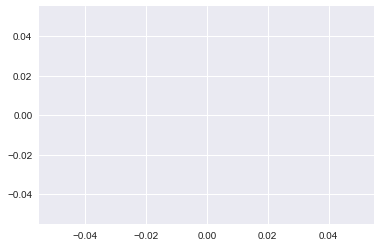

In [406]:

std=np.std(GMMData[0:62,324], axis=0)
mean= np.mean(GMMData[0:62,324])
print(mean,std)
plt.bar(GMMData[0:62,324], stats.norm.pdf(GMMData[0:62,324], mean, std))
print(GMMData[0:62,324])
#plt.bar()


125.75065651093718 14.556768060643934
[128.75487905 119.6901247  128.15768839  93.99755933 105.86115775
 156.66888674 112.34058083 118.77302108 144.75534412 117.34787861
 112.62992846 127.54066695 141.56372401 118.3782626  145.11003647
 121.00519899 112.99682177 136.50161542 139.25341166 119.27002284
 113.66672634 123.07221425 150.64365852 129.05465081 113.04925645
 127.15177522 154.87268689  95.87647025 119.84814371 124.97365852
 123.77016835 130.88053739 109.80041872 131.21740853 124.29724064
 124.95913889 113.75707102 114.60503151 145.9902514  142.28484916
 141.40875063]


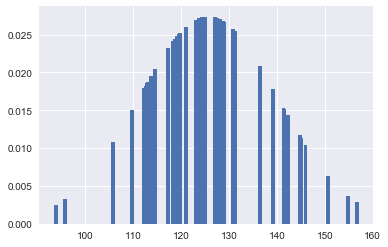

In [408]:
std=np.std(GMMData[66:107,324], axis=0)
mean= np.mean(GMMData[66:107,324])
print(mean,std)
plt.bar(GMMData[66:107,324], stats.norm.pdf(GMMData[66:107,324], mean, std))
print(GMMData[66:107,324])

In [409]:
path="..\\UB_keystroke_dataset\\S1"
files=ReadListOfTextFilesFromDirectoryWalk(path)
# I am training on first 10 users
dataFileFormat=CreateListOfTuplesFromFile(files[0:4])
#print(dataFileFormat[0])
df=CreateDataFrame(dataFileFormat,columns=['Key', 'EventType','Time','User'])
alphabetsDF=ParseAlphabetsKeys(df)
keyDownDownTimeDifference=GetTimeDifferenceofKeyDownDown(data=alphabetsDF)
FeatureVectors=GetDictionaryOfFeatureVectors(keyDownDownTimeDifference) 
usersFV=pd.DataFrame.from_dict(FeatureVectors)
data= GetGMMFormatDataFromDataFrame(usersFV)
data.shape

(61, 676)
(43, 676)
(57, 676)
(30, 676)


(191, 676)

185.0 18.374965149961376
[156. 187. 156. 187. 141. 156. 312. 185. 185. 185. 185. 185. 185. 185.
 185. 185. 185. 185. 185. 185. 185. 185. 185. 185. 185. 185. 185. 185.
 185. 185. 185. 185. 185. 185. 185. 185. 185. 185. 185. 185. 185. 185.
 185. 185. 185. 185. 185. 185. 185. 185. 185. 185. 185. 185. 185. 185.
 185. 185. 185. 185. 185.]


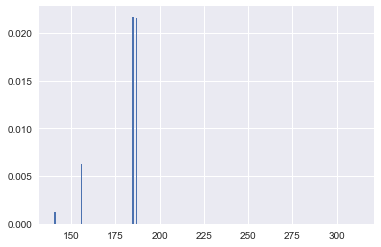

In [387]:

std=np.std(data[0:61,327], axis=0)
mean= np.mean(data[0:61,327])
print(mean,std)
plt.bar(data[0:61,327], stats.norm.pdf(data[0:61,327], mean, std))
print(data[0:61,327])

209.89772727272728 32.50447164088185
[266.  203.5 203.5 203.5 203.5 203.5 203.5 203.5 203.5 203.5 203.5 203.5
 203.5 203.5 203.5 203.5 203.5 203.5 203.5 203.5 203.5 203.5 203.5 203.5
 203.5 203.5 203.5 203.5 203.5 203.5 203.5 203.5 203.5 203.5 203.5 203.5
 203.5 203.5 203.5 203.5 203.5 203.5 212.  414. ]


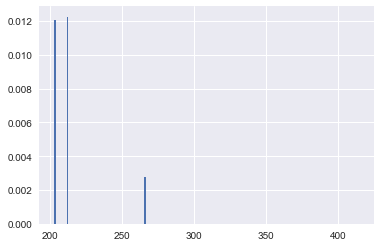

In [385]:

std=np.std(data[62:106,327], axis=0)
mean= np.mean(data[62:106,327])
print(mean,std)
plt.bar(data[62:106,327], stats.norm.pdf(data[62:106,327], mean, std))
print(data[62:106,327])

# print(GMMData[0:66,1])
print(np.std(GMMData[0:66,1], axis=0)
,np.mean(GMMData[0:66,1]))

In [110]:
x1='Z'
x2='P'
(ord(x1)-65)*26+np.absolute(ord(x2)-65)


665

In [61]:
x1='Z'
x2='Z'
(ord(x1)-65)*26+np.absolute(ord(x2)-65)


675

In [62]:
def GetGMMFormatDataFromDataFrame(usersFV):
    GMMData=[]
    for user in usersFV.columns:
        maxLength=0
        for userF in usersFV[user]:
            if userF==0:
                userF=[]
            featureLenght=len(userF)
            if featureLenght > maxLength:
                maxLength=featureLenght
        userDF=pd.DataFrame(index=range(0,676))
        userData=np.zeros((maxLength,676))
        row=0
        for userF in usersFV[user]:
            column=0
            if userF==0:
                userF=[]
            availableValuesCount=len(userF)
            sum=0
            for value in userF:
                userData[column][row]=value
                column=column+1
                sum=sum+value
            if availableValuesCount==0:
                mean=0
            else:
                mean=sum/availableValuesCount
            gussianValues=np.random.normal(mean,3,maxLength-availableValuesCount)
            for value in gussianValues:
            
                userData[column][row]=mean
                column=column+1
        
            row=row+1
        print(userData.shape)
        if len(GMMData)==0:
            GMMData=userData
        else:
            GMMData=np.append(GMMData,userData,axis=0)
    return GMMData


In [63]:
data= GetGMMFormatDataFromDataFrame(usersFV)
len(data)


(66, 676)
(48, 676)


114

In [64]:
def GetAverageFeatureVectors(FeatureVectors):
    
    averageFV= np.zeros(26*26,dtype=object)
    index=0
    for xi in FeatureVectors:
        tempSum=np.array(xi).sum()
        if type(xi)== list:
            averageFV[index]=tempSum/len(xi)
        index=index+1
    return averageFV

In [65]:
for user in FeatureVectors:
    GetAverageFeatureVectors(FeatureVectors[user])

In [47]:
testPath='..\\UB_keystroke_dataset\\UB_keystroke_dataset\\s1\\baseline\\001000.txt'
g = mixture.GMM(n_components=2)
g.fit(data)
np.round(g.weights_, 2)

C:\Users\Muhammad Umsan\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Muhammad Umsan\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Muhammad Umsan\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Muhammad Umsan\Anaconda3\lib\site-packages\sklearn\utils\deprec

array([0.58, 0.42])

In [271]:
def TrainModel(path):
    """Get path of data files and train a GMM model"""
    files=ReadListOfTextFilesFromDirectoryWalk(path)
    # I am training on first 10 users
    dataFileFormat=CreateListOfTuplesFromFile(files[0:4:2])
    #print(dataFileFormat[0])
    df=CreateDataFrame(dataFileFormat,columns=['Key', 'EventType','Time','User'])
    alphabetsDF=ParseAlphabetsKeys(df)
    keyDownDownTimeDifference=GetTimeDifferenceofKeyDownDown(data=alphabetsDF)
    FeatureVectors=GetDictionaryOfFeatureVectors(keyDownDownTimeDifference) 
    usersFV=pd.DataFrame.from_dict(FeatureVectors)
    data= GetGMMFormatDataFromDataFrame(usersFV)
    g = mixture.GMM(n_components=2)
    print(len(data))
    g.fit(data)
    return g
    


In [280]:
GMM= TrainModel("..\\UB_keystroke_dataset\\S0")

('LMenu', 'KeyDown', '63578429757751', '001000')
(65, 676)
(65, 676)
130


C:\Users\Muhammad Umsan\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Muhammad Umsan\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Muhammad Umsan\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Muhammad Umsan\Anaconda3\lib\site-packages\sklearn\utils\deprec

In [281]:
GMM.weights_

array([0.5, 0.5])

In [282]:
def TestModel(path,g):
    """Get path of data files and test a GMM model"""
    GMMData=[]
    files=ReadListOfTextFilesFromDirectoryWalk(path)
    dataFileFormat=CreateListOfTuplesFromFile(files[0:4:2])
    df=CreateDataFrame(dataFileFormat,columns=['Key', 'EventType','Time','User'])
    
    alphabetsDF=ParseAlphabetsKeys(df)
    keyDownDownTimeDifference=GetTimeDifferenceofKeyDownDown(data=alphabetsDF)
    FeatureVectors=GetDictionaryOfFeatureVectors(keyDownDownTimeDifference) 
    usersFV=pd.DataFrame.from_dict(FeatureVectors)
    for user in FeatureVectors:
        print(user)
        data=GetAverageFeatureVectors(FeatureVectors[user])
        dataNP=np.array(data,dtype=np.float64)
        dataNP[np.isnan(dataNP)]=0
        dataNP=dataNP.reshape((1,676))
        
        
        if len(GMMData)==0:
            GMMData=dataNP
        else:
            GMMData=np.append(GMMData,dataNP,axis=0)
    print(GMMData.shape)
    print(len(GMMData))
    
    print(g.predict_proba(GMMData))
    return g.predict(GMMData)
    

In [284]:
predictions=TestModel("..\\UB_keystroke_dataset\\S1",GMM)
predictions
GMM.means_

001100
002100
(2, 676)
2
[[0. 1.]
 [1. 0.]]


C:\Users\Muhammad Umsan\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Users\Muhammad Umsan\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\Muhammad Umsan\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


array([[  0.        , 195.16666667, 351.88888889, ...,   0.        ,
          0.        ,   0.        ],
       [832.33333333, 195.16666667, 335.375     , ...,   0.        ,
          0.        ,   0.        ]])

In [287]:
GMM.covars_.shape

(2, 676)

'diag'